## A image classification pipeline with PyTorch, model can be a single layer Conv2d.
This example uses torchvision.datasets.FakeData as a placeholder dataset (you can replace it with CIFAR-10, MNIST, or your own).

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image
from IPython.display import display
import glob
import os


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Simple NN


In [ ]:
#Define the model
"""
class SingleConvNet(nn.Module):
  def __init__(self, in_channels=1, num_classes=10):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)
    self.pool = nn.AdaptiveAvgPool2d((1, 1))
    self.classifier = nn.Linear(16, num_classes)

  def forward(self, x):
    x = self.conv(x)          # (B, 16, 28, 28)
    x = torch.relu(x)
    x = self.pool(x)          # (B, 16, 1, 1)
    x = torch.flatten(x, 1)   # (B, 16)
    return self.classifier(x) # (B, 10)
    """

## If we want to add a deeper layer

In [ ]:
 import torch.nn.functional as F # Import the functional module

 #Define the model
class SingleConvNet(nn.Module):
  def __init__(self, in_channels=3, num_classes=10): # Assuming 3 input channels from ImageFolder
    super().__init__()
    # First convolutional block
    self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)  # Output: (B, 32, 32, 32) with 32x32 input
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)                 # Output: (B, 32, 16, 16) with 32x32 input

    # Second convolutional block
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)           # Output: (B, 64, 16, 16) with 32x32 input
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)                 # Output: (B, 64, 8, 8) with 32x32 input

    # Calculate the input size for the first fully connected layer
    # Based on the output shape of the last pooling layer: 64 channels, 8x8 spatial dimensions
    fc1_input_features = 64 * 8 * 8 # This should be 4096

    # Fully connected layers
    self.fc1 = nn.Linear(fc1_input_features, 128)
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x):
    # Convolutional layers with ReLU and pooling
    x = F.relu(self.conv1(x))
    x = self.pool1(x)

    x = F.relu(self.conv2(x))
    x = self.pool2(x)

    # Flatten
    x = x.view(x.size(0), -1)  # or torch.flatten(x, 1)

    # Fully connected layers
    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    return x

## VGG16 Incorporated NN


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.models as models

class VGG16Classifier(nn.Module):
    def __init__(self, num_classes=10, in_channels=3):
        super(VGG16Classifier, self).__init__()
        # Load pre-trained VGG16 model from torchvision
        self.vgg16 = models.vgg16(weights = 'DEFAULT')

        # Freeze the VGG16 feature layers
        for param in self.vgg16.parameters():
            param.requires_grad = False

        self.vgg16.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.vgg16.features(x)
        x = self.vgg16.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.vgg16.classifier(x)
        return x

## IGNORE: Zavala Stuff


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
from tensorflow.keras.models import Model
from os.path import dirname
from os.path import basename
import glob
import pickle
import os

In [ ]:
base_model = VGG16(include_top=False,weights='imagenet')

In [ ]:
Layer = 'block1_conv2'
model = Model(inputs=base_model.input, outputs=[base_model.get_layer(Layer).output])

In [ ]:
path_list = glob.glob('/content/drive/My Drive/Frechette Lab/train_dataset/*/*')

In [ ]:
labels = []
Descriptors_tot = []
count = 1

for y in path_list:

    #Load and preprocess images.
    img_path = y
    img = image.load_img(img_path)
    x = image.img_to_array(img)
    x = np.expand_dims(x,axis=0)
    x = preprocess_input(x)

    #Process images and obtain output from selected convolutional filters.
    Descriptors = model.predict(x)

    #Create mean Descriptors from Filters.
    mean_Descriptors = [[] for i in range(len(Descriptors))]

    #Store label of each image.
    label = basename(dirname(img_path))
    labels = np.append(labels,label)

    #Code if extracting more than one layer of features.
    if len(Descriptors) >= 2:
        for j in range(len(Descriptors)):
            label = basename(dirname(img_path))
            for i in range(np.size(Descriptors[j][0,0,0,:])):
                mean_f = np.mean(Descriptors[j][0,:,:,i])
                mean_Descriptors[j] = np.append(mean_Descriptors[j],mean_f)

    #Code if extracting only a single layer of features.
    else:
        for i in range(np.size(Descriptors[0,0,0,:])):
            mean_f = np.mean(Descriptors[0,:,:,i])
            mean_Descriptors = np.append(mean_Descriptors,mean_f)

    #Create large dictionary containing all descriptors.
    Descriptors_tot.append(mean_Descriptors[:])

    #Count to completion
    frac = count/len(path_list)
    print('\x1b[2K\r Percent Done {0}'.format(frac*100), end="\r"),
    count += 1

In [ ]:
with open('/content/drive/My Drive/Frechette Lab/Pickle Files/Descriptors001','wb') as fp:
    pickle.dump(Descriptors_tot,fp)

with open('/content/drive/My Drive/Frechette Lab/Pickle Files/Labels001','wb') as fp:
    pickle.dump(labels,fp)

### SVM Classifier

In [ ]:
import pickle
from sklearn.svm import LinearSVC
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from scipy.stats.mstats import zscore
from sklearn.decomposition import PCA
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [ ]:
with open('/content/drive/My Drive/Frechette Lab/Pickle Files/Descriptors001','rb') as fp:
    Descriptors = pickle.load(fp)

with open('/content/drive/My Drive/Frechette Lab/Pickle Files/Labels001','rb') as fp:
    Labels = pickle.load(fp)

In [ ]:
Descriptors = np.vstack(Descriptors)
Descriptors = zscore(Descriptors,axis = 0)

In [ ]:
lb = preprocessing.LabelBinarizer()
Labels = lb.fit_transform(Labels)

In [ ]:
clf = LinearSVC(penalty='l1',loss='squared_hinge',dual=False)

In [ ]:
scores = cross_val_score(clf,Descriptors,np.squeeze(Labels),cv=4, scoring = 'f1')
print("f1: %0.2f (+/- %0.1f)" % (scores.mean(), scores.std()))

In [ ]:
clf.fit(Descriptors,np.squeeze(Labels))
weights = clf.coef_

In [ ]:
ind = np.argsort(np.absolute(weights))
top12 = ind[0][-12:]
print('top 12 weights {0}'.format(top12))

In [ ]:
signs = np.sign(weights[0][top12])
print('sign of weights{} with positive class PE_1um_PBSxHEX_with lipids_1hr and negative class PE_1um_PBSxHEX_no lipids_1hr'.format(signs))

In [ ]:
Sum = np.sum(np.absolute(weights))
dev = []
for i in top12:
    j = 100*np.absolute(weights[0][i])/Sum
    dev.append(float(j))
print('Percent of Total Assigned Weight {}'.format(dev))

In [ ]:
Descriptors1 = Descriptors[:,top12]
scores = cross_val_score(clf,Descriptors1,np.squeeze(Labels),cv = 4, scoring = 'f1')
print("f1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
clf.fit(Descriptors1,np.squeeze(Labels))
weights1 = clf.coef_
ind = np.argsort(np.absolute(weights1))
top12value = top12[ind]
top121 = ind[0][-12:]
print('top 10 weights {0}'.format(top12value))

In [ ]:
signs1 = np.sign(weights1[0][top121])
print('sign of weights{} with positive class "with lipids"'.format(signs1))

In [ ]:
Sum = np.sum(np.absolute(weights1))
dev = []
for i in top121:
    j = 100*np.absolute(weights1[0][i])/Sum
    dev.append(float(j))
print('Percent of Total Assigned Weight {}'.format(dev))

## Preprocessing


In [ ]:
# First crops 1440 x 1080 images into 24 224 x 224 images.
import os

path_list = glob.glob('/content/drive/My Drive/Frechette Lab/train_dataset/*/*')
output_base_dir = '/content/drive/My Drive/Frechette Lab/train_processed_dataset' # New base directory for processed images

def preprocess(image_path, output, crop_height=224, crop_width=224):
    img = Image.open(image_path)
    width, height = img.size
    rows = height // crop_height
    cols = width // crop_width

    base_name = os.path.splitext(os.path.basename(image_path))[0]
    ext = os.path.splitext(os.path.basename(image_path))[1]

    # Get the class name from the immediate parent directory of the image
    class_name = os.path.basename(os.path.dirname(image_path))

    # Construct the output directory using the new base and the class name
    output_dir = os.path.join(output, class_name)
    os.makedirs(output_dir, exist_ok=True) # Create directory if it doesn't exist

    for i in range(rows):
        for j in range(cols):
            left = j * crop_width
            upper = i * crop_height
            right = left + crop_width
            lower = upper + crop_height
            cropped_img = img.crop((left, upper, right, lower))
            # Construct the new filename using the original base name and extension
            new_filename = f"{base_name}_{i}_{j}{ext}"
            save_path = os.path.join(output_dir, new_filename)
            cropped_img.save(save_path)

for y in path_list:
    preprocess(y, output = output_base_dir)
    print(f"File {y} preprocessed")

File /content/drive/My Drive/Frechette Lab/train_dataset/PE_1um_PBSxHEX_no lipids_1hr/Copy of 0301-8-nolipids-1hr-scale0000.png preprocessed
File /content/drive/My Drive/Frechette Lab/train_dataset/PE_1um_PBSxHEX_no lipids_1hr/Copy of 130514.094.bmp preprocessed
File /content/drive/My Drive/Frechette Lab/train_dataset/PE_1um_PBSxHEX_no lipids_1hr/Copy of 133521.785.bmp preprocessed
File /content/drive/My Drive/Frechette Lab/train_dataset/PE_1um_PBSxHEX_no lipids_1hr/Copy of 164155.858.bmp preprocessed
File /content/drive/My Drive/Frechette Lab/train_dataset/PE_1um_PBSxHEX_no lipids_1hr/Copy of 164759.745.bmp preprocessed
File /content/drive/My Drive/Frechette Lab/train_dataset/PE_1um_PBSxHEX_no lipids_1hr/Copy of 171352.302.bmp preprocessed
File /content/drive/My Drive/Frechette Lab/train_dataset/PE_1um_PBSxHEX_no lipids_1hr/Copy of 140743.293.bmp preprocessed
File /content/drive/My Drive/Frechette Lab/train_dataset/PE_1um_PBSxHEX_no lipids_1hr/Copy of 164134.452.bmp preprocessed
File 

## Dataset and Data loader

In [ ]:
try:
    # Using the pre-defined transform from the notebook
    train_dataset = datasets.ImageFolder(root=image_data_root, transform=transform)
    print(f"Found {len(train_dataset)} images belonging to {len(train_dataset.classes)} classes.")

    # Increase num_workers for faster data loading by using multiple processes
    # The optimal number of workers depends on your system and dataset size.
    # A common starting point is the number of CPU cores.
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2) # You can adjust num_workers
    print("DataLoader created successfully.")

except Exception as e:
    print(f"Error creating ImageFolder dataset: {e}")
    print("Please ensure the directory structure in")
    print(f"{image_data_root} follows the ImageFolder convention (subdirectories for classes).")
    print("Also check file permissions and that the directory exists.")

Found 27 images belonging to 3 classes.
DataLoader created successfully.


In [ ]:
path_list = glob.glob('/content/drive/My Drive/Frechette Lab/train_dataset/*/*')
output_base_dir = '/content/drive/My Drive/Frechette Lab/train_processed_dataset'
try:
    train_dataset = datasets.ImageFolder(root= '/content/drive/My Drive/Frechette Lab/train_dataset', transform=transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()]))
    print(f"Found {len(train_dataset)} images belonging to {len(train_dataset.classes)} classes.")

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    print("DataLoader created successfully.")

except Exception as e:
    print(f"Error creating ImageFolder dataset: {e}")
    print("Please ensure the directory structure in")
    print(f"{output_base_dir} follows the ImageFolder convention (subdirectories for classes).")
    print("Also check file permissions and that the directory exists.")

Found 27 images belonging to 3 classes.
DataLoader created successfully.


## Show Images

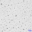

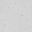

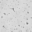

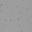

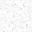

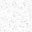

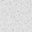

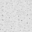

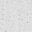

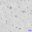

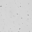

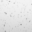

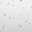

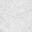

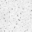

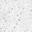

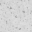

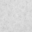

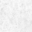

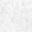

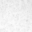

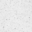

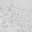

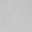

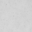

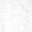

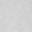

In [ ]:
# To view transformed images

def showimg(dataset):
    for image, labels in dataset:
        to_pil = transforms.ToPILImage()
        image = to_pil(image)
        display(image)

showimg(train_dataset)


## Training loop

In [ ]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

In [ ]:
import matplotlib.pyplot as plt

# Track epoch loss and accuracy for plotting
epoch_losses = []
epoch_accuracies = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# which model to use
model_dict = {
    'SimpleNet': {
        'path': "/content/drive/My Drive/Frechette Lab/SimpleNet_weights.pt",
        'model': SingleConvNet(in_channels=3).to(device)
    },
    'VGG16Classifier': {
        'path': "/content/drive/My Drive/Frechette Lab/VGG16Classifier_weights.pt",
        'model': VGG16Classifier(in_channels=3).to(device)
    }
}

WEIGHTS_PATH = model_dict['VGG16Classifier']['path']
model = model_dict['VGG16Classifier']['model']

# Load saved weights
try:
    state_dict = torch.load(WEIGHTS_PATH, map_location=device)
    model.load_state_dict(state_dict)
    print(f"Successfully loaded model weights from {WEIGHTS_PATH}")
except FileNotFoundError:
    print(f"Warning: Weights file not found at {WEIGHTS_PATH}. Starting training with random initialization.")
except RuntimeError as e:
    print(f"Error loading state_dict: {e}")
    print("This might happen if the model architecture does not match the saved weights.")
    print("Starting training with random initialization.")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

TEST_PATH = glob.glob('/content/drive/My Drive/Frechette Lab/test_dataset/*/*')
test_output = '/content/drive/My Drive/Frechette Lab/test_processed_dataset'
for image in TEST_PATH:
    preprocess(image, output = test_output)
test_dataset = datasets.ImageFolder(root=test_output, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print("Starting training...")
for epoch in range(10):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_loss)

    #evaluate
    accuracy = evaluate(model, test_loader)
    epoch_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

print("Training finished.")

# Save updated weights
try:
    torch.save(model.state_dict(), WEIGHTS_PATH)
    print(f"Successfully saved updated model weights to {WEIGHTS_PATH}")
except Exception as e:
    print(f"Error saving model weights: {e}")

epochs = range(1, len(epoch_losses) + 1)

#Plot the loss over epochs
plt.figure()
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.show()

#Plot the accuracy over epochs
plt.figure()
plt.plot(range(1, len(epoch_accuracies) + 1), [a for a in epoch_accuracies], marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy Over Epochs")
plt.grid(True)
plt.show()

Starting training...


KeyboardInterrupt: 

## Test evaluation
add a test set in a similar way with model.eval() and no gradients

In [ ]:

TEST_PATH = "/content/drive/My Drive/Frechette Lab/test_dataset"
test_dataset = datasets.ImageFolder(root=TEST_PATH, transform=transform)
print(f"Found {len(test_dataset)} images belonging to {len(test_dataset.classes)} classes.")
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
evaluate(model, test_loader)

Found 10 images belonging to 3 classes.


20.0

## Load PNG dataset and resize

If you have raw .png images (like MNIST digits stored as PNGs), here's a PyTorch-compatible pipeline to:

Load the image from disk

Transform it to tensor

Normalize / resize if needed

Feed it into your SingleConvNet

In [ ]:
from PIL import Image
import torch
from torchvision import transforms

# 1. Define transform (for MNIST-like PNGs)
transform = transforms.Compose([
    transforms.Grayscale(),        # ensure it's single-channel
    transforms.Resize((28, 28)),   # resize to 28x28 if needed
    transforms.ToTensor(),         # convert to tensor in [0,1], shape (1, 28, 28)
])

# 2. Load PNG image
#image_path =  '/content/drive/My Drive/Machine learning and DL/CNN_MNP_GUV/PE_no lipids_1hr/0301-8-nolipids-1hr-scale0000.png'
image_path =  '/content/drive/My Drive/Machine learning and DL/CNN_MNP_GUV/number2.png'

img = Image.open(image_path).convert('RGB')  # or 'L' for grayscale

# 3. Apply transform
tensor_img = transform(img)  # shape: (1, 28, 28)

# 4. Add batch dimension and move to device
input_tensor = tensor_img.unsqueeze(0).to("cuda" if torch.cuda.is_available() else "cpu")

# 5. Model inference
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    predicted_label = output.argmax(dim=1).item()

print(f"Predicted Label: {predicted_label}")

## Notes
.unsqueeze(0) adds the batch dimension: from (1, 28, 28) to (1, 1, 28, 28)

If your model expects RGB (unlikely for MNIST), skip transforms.Grayscale()

If your PNGs are already 28×28 grayscale, just use ToTensor() safely

Next; a batch loader for multiple PNG files in a folder.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

After running the cell above and following the instructions to mount your Google Drive, your files will be accessible under `/content/drive/My Drive/`. You'll need to update the `image_path` in the code to reflect the actual location of your image file within your Google Drive.

For example, if you uploaded the image to a folder named `Training data` in your Google Drive, the path might look like this:

In [ ]:
image_path = '/content/drive/My Drive/Training data/PE_no lipids_1hr/0301-8-nolipids-1hr-scale0000.png'